# Sentiment Analysis using twitter data

Simple Deep Neural Network, that predicts tweet sentiment. The model can be greatly improved using various <br/>
word vectorization techniques and Recurrent Neural Networks.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.model_selection import train_test_split
import tflearn as tflearn
from nltk.corpus import stopwords
import preprocessor as p
import re
import numpy as np
from sklearn import preprocessing
import tensorflow as tf

In [2]:

test_path = "./data/twitter_test.txt"
training_path = "./data/twitter_data.txt"

def all_stop_words():
    stop_words = stopwords.words('english')
    add_stopwords = [",", "*" , ")" , "(" ,".","theres","know","one","though","vinci","ive","da","book","im","went",
                    "potter","brokeback","mountain","harry","code","mission","impossible","movie","movies","i","ya",
                    "yet","yall"]
    for w in add_stopwords:
        stop_words.append(w)
    return stop_words


stop_words = all_stop_words()
def training_data_df(path):
    
    training_data = open(path,mode='r')
    training_array =[]
    for d in training_data:
        training_dict = {}
        sent_tweet_array = d.split('\t')
        training_dict['tweet'] = sent_tweet_array[1].lower()
        training_dict['cleaned_tweet'] =remove_stop_words(sent_tweet_array[1].lower())
        training_dict['positive'] =int(sent_tweet_array[0])
        training_array.append(training_dict)
    training_df = pd.DataFrame(training_array)
    return training_df

def sentiment(sentiment_prob):
    if sentiment_prob[0]>sentiment_prob[1]:
        return "positive"
    return "negative"

def remove_stop_words(tweet_text):
    tweet_text = re.sub(r'[?|$|.|!]',r'',tweet_text)
    tweet_text = re.sub(r'[^a-zA-Z0-9 ]',r'',tweet_text)
    result = ""
    for word in tweet_text.split():            
        result = result +" "+word.lower()

    return result.lstrip()

def get_word_frequency(tweet_list):
    word_dict = {} 
    result_array=[]
    for tw in tweet_list:
        for word in tw.split():
            if word in word_dict.keys():
                word_dict[word] = word_dict[word]+1
                continue
            word_dict[word] = 1
    for k in word_dict.keys():
        result_array.append({'word':k, 'count':word_dict[k]})
    return pd.DataFrame(result_array,columns=['count','word'])


def common_pos_words(df_data):
    return common_words_filter(df_data,1)

def common_neg_words(df_data):
    return common_words_filter(df_data,0)

def common_words_filter(df_data,sent):
    pos_tweet =df_data[df_data["positive"] ==sent]
    all_tweets = pos_tweet["tweet"].str.cat(sep='|')
    common_words=[]
    for pos_tw in pos_tweet["tweet"]:
        for tw in all_tweets.split('|'):
            if pos_tw == tw:
                continue
            tw_list = list(tw.split())
            pos_list = list(pos_tw.split())
            inter = list(set(tw_list).intersection(pos_list))
            for word in inter:
                if word not in common_words:
                    common_words.append(word)
    return common_words

In [3]:
training_data = training_data_df(training_path)
# test_data = training_data_df(test_path)
training_data["neg"] = training_data["positive"].apply(lambda x: 0 if x==1 else 1)
vect = CountVectorizer(stop_words=all_stop_words())
print("All data:",training_data.shape[0])
# print("Test data:",test_data.shape[0])

All data: 7087


In [4]:
training_data.head(10)


,cleaned_tweet,positive,tweet,neg
0,i feeel like aaa reetard,0,i feeel like aaa reetard\n,1
1,the da vinci code book is just awesome,1,the da vinci code book is just awesome.\n,0
2,this was the first clive cussler ive ever read...,1,this was the first clive cussler i've ever rea...,0
3,i liked the da vinci code a lot,1,i liked the da vinci code a lot.\n,0
4,i liked the da vinci code a lot,1,i liked the da vinci code a lot.\n,0
5,i liked the da vinci code but it ultimatly did...,1,i liked the da vinci code but it ultimatly did...,0
6,thats not even an exaggeration and at midnight...,1,that's not even an exaggeration ) and at midni...,0
7,i loved the da vinci code but now i want somet...,1,"i loved the da vinci code, but now i want some...",0
8,i thought da vinci code was great same with ki...,1,"i thought da vinci code was great, same with k...",0
9,the da vinci code is actually a good movie,1,the da vinci code is actually a good movie...\n,0


In [5]:
training_data = training_data[['positive','neg','cleaned_tweet', 'tweet']]
training_data.values

array([[0, 1, 'i feeel like aaa reetard', 'i feeel like aaa reetard\n'],
       [1, 0, 'the da vinci code book is just awesome',
        'the da vinci code book is just awesome.\n'],
       [1, 0,
        'this was the first clive cussler ive ever read but even books like relic and da vinci code were more plausible than this',
        "this was the first clive cussler i've ever read, but even books like relic, and da vinci code were more plausible than this.\n"],
       ..., 
       [0, 1,
        'as i sit here watching the mtv movie awards i am reminded of how much i despised the movie brokeback mountain',
        'as i sit here, watching the mtv movie awards, i am reminded of how much i despised the movie brokeback mountain.\n'],
       [0, 1, 'ok brokeback mountain is such a horrible movie',
        'ok brokeback mountain is such a horrible movie.\n'],
       [0, 1, 'oh and brokeback mountain was a terrible movie',
        'oh, and brokeback mountain was a terrible movie.\n']], dty

### One-hot Encode

In [6]:
vect.fit(training_data["cleaned_tweet"])
word_matrix = vect.transform(training_data["cleaned_tweet"]).toarray()
print(word_matrix.shape)

(7087, 2072)


In [7]:
num_features = word_matrix.shape[1]
print("Total features: ",num_features)
classes = training_data.values[:,:2]

Total features:  2072


In [8]:
trX,testX,trY,testY = train_test_split(word_matrix,classes)   
print("Training data:",trX.shape[0])
print("Test data:",testX.shape[0])

Training data: 5315
Test data: 1772


# Deep Neural Network


Consists of : 
<ul>
<li>Input layer </li> 
<li>Hidden layer with 300 neurons</li> 
<li>Output softmax layer, which outputs the likelyhood of a class: [1,0]</li>
</ul>

<img src="./data/nn-architecture.png"/>

In [10]:
tf.reset_default_graph()
input_data = tflearn.input_data(shape=[None, num_features])
init_weights = tflearn.initializations.truncated_normal(shape=None,dtype=tf.float32, seed=None)
layer1 = tflearn.layers.fully_connected(input_data,300,activation='sigmoid',weights_init=init_weights,regularizer='L2')
dp = tflearn.dropout(layer1,0.5)
net  =tflearn.layers.fully_connected(dp , 2,activation='softmax',regularizer='L2')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy')
model = tflearn.DNN(net,tensorboard_verbose=3)


In [167]:
model.fit(trX,trY,n_epoch=10,show_metric=True)
evl = model.evaluate(testX,testY)
print("Evaluation: ",evl)

Training Step: 839  | total loss: 0.10739 | time: 5.976s
| Adam | epoch: 010 | loss: 0.10739 - acc: 0.9725 -- iter: 5312/5315
Training Step: 840  | total loss: 0.10491 | time: 6.046s
| Adam | epoch: 010 | loss: 0.10491 - acc: 0.9722 -- iter: 5315/5315
--
Evaluation:  [0.98702031454706296]


             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       791
        1.0       0.99      0.99      0.99       981

avg / total       0.99      0.99      0.99      1772

[[780  11]
 [  8 973]]
AUC = 0.9890


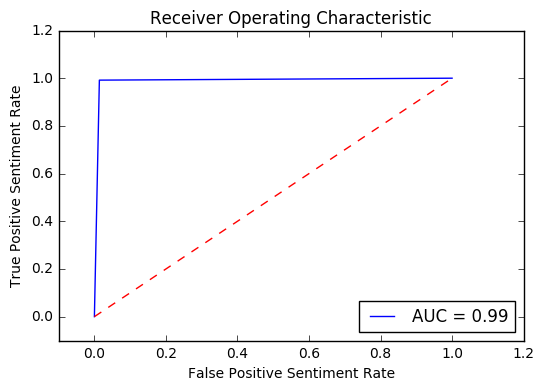

In [160]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
def auc_curve():
    test_y=testY[:,0]
    pred = []
    i=0
    for t in testX:
        p = model.predict([t])
        p_toarray = np.asarray(p)[0]
        if p_toarray[0]>p_toarray[1]:
            pred.append(1.0)
        else:
            pred.append(0.0)
    print(metrics.classification_report(test_y.astype(float), np.asarray(pred)))
    print(metrics.confusion_matrix(test_y.astype(float), pred))
    fpr, tpr, thresholds = metrics.roc_curve(test_y, np.asarray(pred))
    roc_auc = auc(fpr, tpr)
    print('AUC = %0.4f'% roc_auc)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Sentiment Rate')
    plt.xlabel('False Positive Sentiment Rate')
    plt.show()
    

auc_curve()

# Inspecting training data

### Positive sentiment

In [161]:
for t in training_data[training_data["positive"] ==1]["tweet"].head(10):
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: the da vinci code book is just awesome.

[ 0.95302999  0.04696997]
sentiment: positive
--------
Tweet: this was the first clive cussler i've ever read, but even books like relic, and da vinci code were more plausible than this.

[ 0.87887669  0.12112329]
sentiment: positive
--------
Tweet: i liked the da vinci code a lot.

[ 0.72634131  0.27365869]
sentiment: positive
--------
Tweet: i liked the da vinci code a lot.

[ 0.72634131  0.27365869]
sentiment: positive
--------
Tweet: i liked the da vinci code but it ultimatly didn't seem to hold it's own.

[ 0.80330151  0.19669852]
sentiment: positive
--------
Tweet: that's not even an exaggeration ) and at midnight we went to wal-mart to buy the da vinci code, which is amazing of course.

[ 0.27423972  0.72576028]
sentiment: negative
--------
Tweet: i loved the da vinci code, but now i want something better and different!..

[ 0.91149944  0.08850054]
sentiment: positive
--------
Tweet: i thought da vinci code was great, same with kit

### Negative sentiment

In [156]:

for t in training_data[training_data["positive"] ==0]["tweet"].head(10):
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: i feeel like aaa reetard

[ 0.57383108  0.42616895]
sentiment: positive
--------
Tweet: da vinci code was a terrible movie.

[ 0.46458665  0.53541332]
sentiment: negative
--------
Tweet: then again, the da vinci code is super shitty movie, and it made like 700 million.

[ 0.49910405  0.50089592]
sentiment: negative
--------
Tweet: the da vinci code comes out tomorrow, which sucks.

[ 0.41503838  0.58496159]
sentiment: negative
--------
Tweet: i thought the da vinci code movie was really boring.

[ 0.47030842  0.52969158]
sentiment: negative
--------
Tweet: god, yahoo games has this truly-awful looking da vinci code-themed skin on it's chessboard right now.

[ 0.49093878  0.50906122]
sentiment: negative
--------
Tweet: da vinci code does suck.

[ 0.46278223  0.53721774]
sentiment: negative
--------
Tweet: and better...-we all know da vinci code is bogus and inaccurate.

[ 0.43719253  0.56280756]
sentiment: negative
--------
Tweet: last time, da vinci code is also a bit disappoint

### Custom data

In [157]:
testing_tweets = ["this was ok","I like this product but I am not satisfied","I FEEEL LIKE AAA REETARD"
]
for t in testing_tweets:
    print("Tweet:",t)
    enc = vect.transform([t]).toarray()
    p = model.predict(enc)
    print(np.asarray(p)[0])
    print("sentiment:",sentiment(np.asarray(p)[0]))
    print('--------')

Tweet: this was ok
[ 0.51919967  0.48080033]
sentiment: positive
--------
Tweet: I like this product but I am not satisfied
[ 0.5688349   0.43116507]
sentiment: positive
--------
Tweet: I FEEEL LIKE AAA REETARD
[ 0.57383108  0.42616895]
sentiment: positive
--------


In [206]:
print(vect.transform(["satisfied"]))